In [65]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [66]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [67]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Sitting", "Jogging"]

In [68]:
df = pd.read_csv('C:/Users/abc99/OneDrive/바탕 화면/2023 2학기 파일 전체 모음/딥러닝응용/WISDM.csv', index_col=0)

In [69]:
credit = df[['activity']]
credit = pd.get_dummies(credit, columns=['activity'])
credit

,activity_Downstairs,activity_Jogging,activity_Sitting,activity_Standing,activity_Upstairs,activity_Walking
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
1098199,0,0,1,0,0,0
1098200,0,0,1,0,0,0
1098201,0,0,1,0,0,0
1098202,0,0,1,0,0,0


In [70]:
X_train, X_test = train_test_split(credit, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((702849, 6), (175713, 6), (219641, 6))

In [71]:
credit

,activity_Downstairs,activity_Jogging,activity_Sitting,activity_Standing,activity_Upstairs,activity_Walking
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
1098199,0,0,1,0,0,0
1098200,0,0,1,0,0,0
1098201,0,0,1,0,0,0
1098202,0,0,1,0,0,0


In [72]:
X_train = X_train[X_train.activity_Sitting == 0]
X_train = X_train.drop(['activity_Sitting'], axis=1)

X_val = X_val[X_val.activity_Sitting == 0]
X_val = X_val.drop(['activity_Sitting'], axis=1)

y_test = X_test['activity_Sitting']
X_test = X_test.drop(['activity_Sitting'], axis=1)

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [73]:
from sklearn.preprocessing import StandardScaler

# Normalize the above splits using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

In [74]:
X_train.shape

(664436, 5)

In [75]:
NUM_COL = 30

In [76]:
#Setting the Hyperparameters

#learning_rate = 0.00001
learning_rate = 0.0001
batch_size = 512
epochs = 5
adam = Adam(learning_rate = learning_rate, beta_1 = 0.5)

In [100]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(5))
    generator.add(Activation('tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    return generator

In [104]:
def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=5, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return discriminator

In [105]:
def get_gan_network(discriminator, generator, optimizer,input_dim=NUM_COL):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    
    return gan

In [108]:
from keras.models import Sequential
from keras import initializers
from keras.layers import Activation

#Training the GAN

#Calculating the number of batches based on the batch size
batch_count = X_train.shape[0] // batch_size
pbar = tqdm(total= epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=NUM_COL)


for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,NUM_COL])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = X_train[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, NUM_COL])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss)) 

 20%|███████████████▋                                                              | 1300/6485 [00:59<04:10, 20.71it/s]

Epoch 0 Batch 1296/1297 [D loss: 0.189979] [G loss:2.149836]


 40%|███████████████████████████████▏                                              | 2598/6485 [01:57<03:06, 20.83it/s]

Epoch 1 Batch 1296/1297 [D loss: 0.049547] [G loss:3.314170]


 60%|██████████████████████████████████████████████▊                               | 3895/6485 [02:56<01:58, 21.90it/s]

Epoch 2 Batch 1296/1297 [D loss: 0.000030] [G loss:30.198742]


 80%|██████████████████████████████████████████████████████████████▍               | 5190/6485 [04:07<01:32, 13.97it/s]

Epoch 3 Batch 1296/1297 [D loss: 0.000037] [G loss:41.879837]


100%|██████████████████████████████████████████████████████████████████████████████| 6485/6485 [06:08<00:00, 13.93it/s]

Epoch 4 Batch 1296/1297 [D loss: 0.000002] [G loss:55.397602]


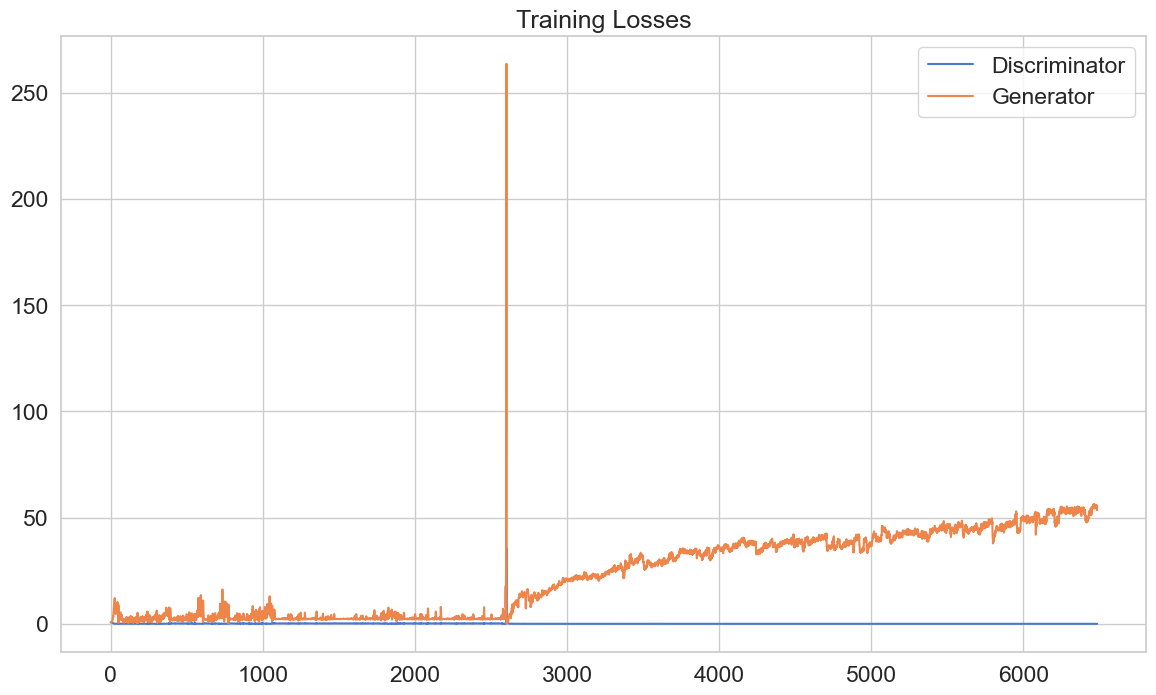

In [109]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [110]:
# Predictions on the test set

nr_batches_test = np.ceil(X_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

100%|██████████████████████████████████████████████████████████████████████████████| 6485/6485 [06:28<00:00, 13.93it/s]

In [111]:
results

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       3.39984626e-06, 1.00000000e+00, 1.00000000e+00])

In [112]:
y2 = y_test.to_numpy()

In [113]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y2)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for Normal data :', results_df.loc[results_df['y_test'] == 1, 'results'].mean() )
print ('Mean score for Fall data :', results_df.loc[results_df['y_test'] == 0, 'results'].mean())

Mean score for Normal data : 3.399846264073858e-06
Mean score for Fall data : 1.0


In [114]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [116]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 1.0
Precision : 1.0
Recall : 1.0
F1 : 1.0
